In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, \
                            auc,\
                            f1_score, \
                            recall_score, \
                            precision_score, \
                            classification_report

import sys
sys.path.append("../src")
# from utils import prepare_U_L_data, \
#                   self_trainer, \
#                   data_sampler, \
#                   evaluate_model
from semi_supervised import SemiSupervisedData

In [21]:
n_samples=1500
n_features=2
data = make_classification(n_samples=n_samples,
                           n_classes=2,
                           weights=[0.5,0.5],
                           n_features=n_features,
                           n_clusters_per_class=1,
                           n_informative=n_features, 
                           n_redundant=0, 
                           n_repeated=0,
                           flip_y=0.,
                           random_state=42
                          )
feature_cols = [f'x{i}' for i in range(1,n_features+1)]
target_col = 'y'
X = pd.DataFrame(data[0], columns = feature_cols)
y = pd.DataFrame(data[1], columns = [target_col])
df = pd.concat([X, y], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
print(df_train.shape)
df.head(3)

(1050, 3)


,x1,x2,y
0,-2.799877,-0.136802,0
1,-1.367893,1.101364,0
2,-1.372660,0.543190,0


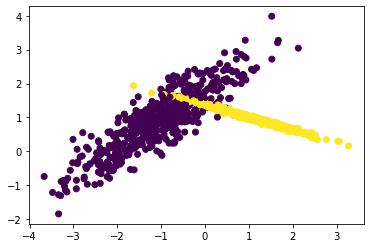

In [22]:
pl.scatter(df_train['x1'], df_train['x2'], c=df_train['y'])

### Perform Analysis using `SemiSupervisedData`

In [23]:
data_semi = SemiSupervisedData.from_dataframe(df_train, feature_cols, target_col)

In [24]:
data_semi.mask(0.6)

In [25]:
prob_thres = 0.95
sgd = SGDClassifier(loss='log', n_jobs=-1)
cl_self = Pipeline([('self-clf', SelfTrainingClassifier(sgd, threshold=prob_thres))])

In [26]:
df_test[feature_cols].iloc[0]

x1   -0.448572
x2    1.444158
Name: 1116, dtype: float64

In [27]:
cl_self.fit(df_train[feature_cols], df_train[target_col])
probs = cl_self.predict_proba(df_test[feature_cols])

/Users/cm-amin/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


In [28]:
def semi_training(model, num_realization, l_frac, u_frac, feature_cols):
    """Semi-supervosed training on shuffled samples with provided 
    classifier.
    """
    proxy_ratios = []
    rocs = []
    for i in range(num_realization):
            x, y, y_mask = data_semi.sample(l_frac=l_frac, u_frac=u_frac)
            cl_self.fit(x, y_mask)
            test_predict = cl_self.predict(df_test[feature_cols])
            # select ulabeled datapoints         
            x_u = x[y_mask == -1]
            y_u = y[y_mask == -1]
            # get prediction probabilities
            probs = cl_self.predict_proba(x_u)
            # mask probabilities higher than threshold
            u_trained_on_mask = probs.max(axis=1)>prob_thres
            # Misslaccification rate
            correct_sum = (probs.argmax(axis=1)[u_trained_on_mask] == y_u[u_trained_on_mask]).sum()
            prx_rate = correct_sum/y_u.size
            proxy_ratios.append(prx_rate)
            rocs.append(roc_auc_score(df_test[target_col], test_predict))
        
    return rocs, proxy_ratios

In [42]:
num_realization = 10
l_range = np.linspace(0.05, 0.6, 10)
u_range = np.linspace(0.01, 1., 3)
rocs_avg = {}
rocs_std = {}
proxy_acc_avg = {}
proxy_acc_std = {}
for i, u_frac in enumerate(u_range):
    rocs_avg[i] = []
    rocs_std[i] = []
    proxy_acc_avg[i] = []
    proxy_acc_std[i] = []
    for l_frac in l_range:
        rocs, proxy_ratios = semi_training(cl_self, 
                                           num_realization=num_realization, 
                                           l_frac=l_frac, 
                                           u_frac=u_frac, 
                                           feature_cols=feature_cols)        
        # Mean and std of ROC scores
        rocs_avg[i].append(np.mean(rocs))
        rocs_std[i].append(np.std(rocs))
        # Mean and std of proxy label classification
        proxy_acc_avg[i].append(np.mean(proxy_ratios))
        proxy_acc_std[i].append(np.mean(proxy_ratios))

### Plot

- ROC scores against number of **labeled** dataset
- ROC scores against number of **unlabeled** dataset

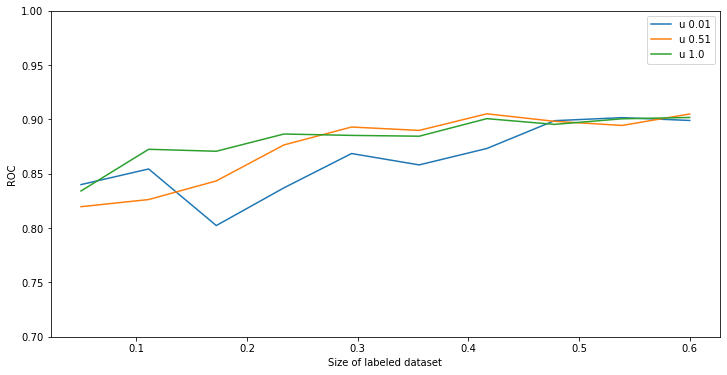

In [43]:
fig, ax = pl.subplots(1, 1, figsize=(12,6))
for i, u in enumerate(u_range):
#     ax.errorbar(l_range, rocs_avg[i], rocs_std[i], label="ROC")
    ax.plot(l_range, rocs_avg[i], label=f"u {u:.2}")
#     ax.plot(l_range, proxy_acc_avg[i], label="Unlabeled Acc")
#     ax.set_title(f"unlabeled: {u:.2} %")
    
pl.ylim(0.7, 1.)
pl.xlabel("Size of labeled dataset")
pl.ylabel("ROC")
pl.legend()

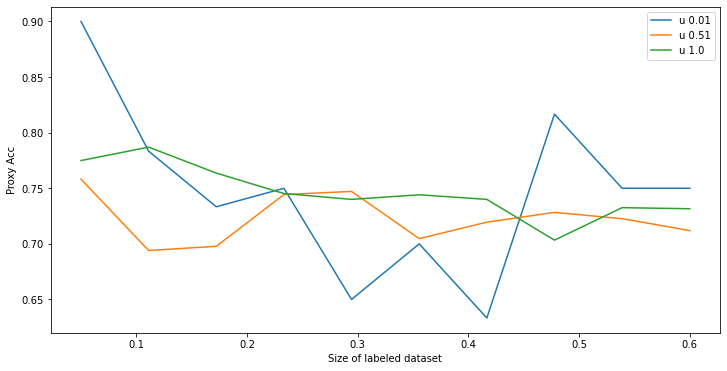

In [44]:
fig, ax = pl.subplots(1, 1, figsize=(12,6))
for i, u in enumerate(u_range):
#    ax.errorbar(l_range, proxy_acc_avg[i], proxy_acc_std[i], label="proxy")
    ax.plot(l_range, proxy_acc_avg[i], label=f"u {u:.2}")
#     ax.plot(l_range, proxy_acc_avg[i], label="Unlabeled Acc")
#     ax.set_title(f"unlabeled: {u:.2} %")
    
pl.xlabel("Size of labeled dataset")
pl.ylabel("Proxy Acc")
pl.legend()

In [13]:
u_range.size

3

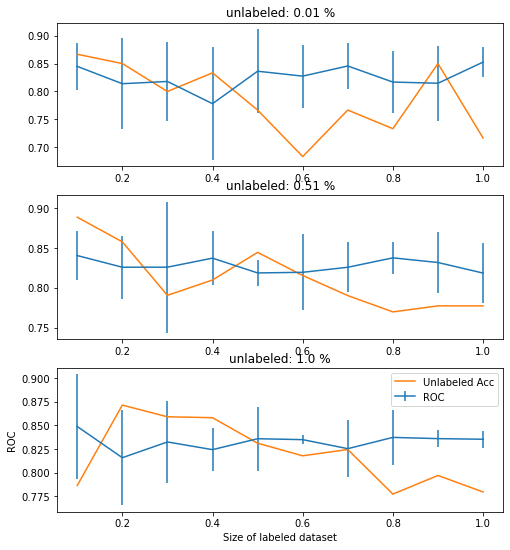

In [14]:
num_ax = u_range.size
fig, ax = pl.subplots(num_ax, 1, figsize=(8,num_ax*3.))
for i, u in enumerate(u_range):
    ax[i].errorbar(l_range, rocs_avg[i], rocs_std[i], label="ROC")
    ax[i].plot(l_range, proxy_acc_avg[i], label="Unlabeled Acc")
    ax[i].set_title(f"unlabeled: {u:.2} %")
    
pl.xlabel("Size of labeled dataset")
pl.ylabel("ROC")
pl.legend()

NameError: name 'roc_scores' is not defined

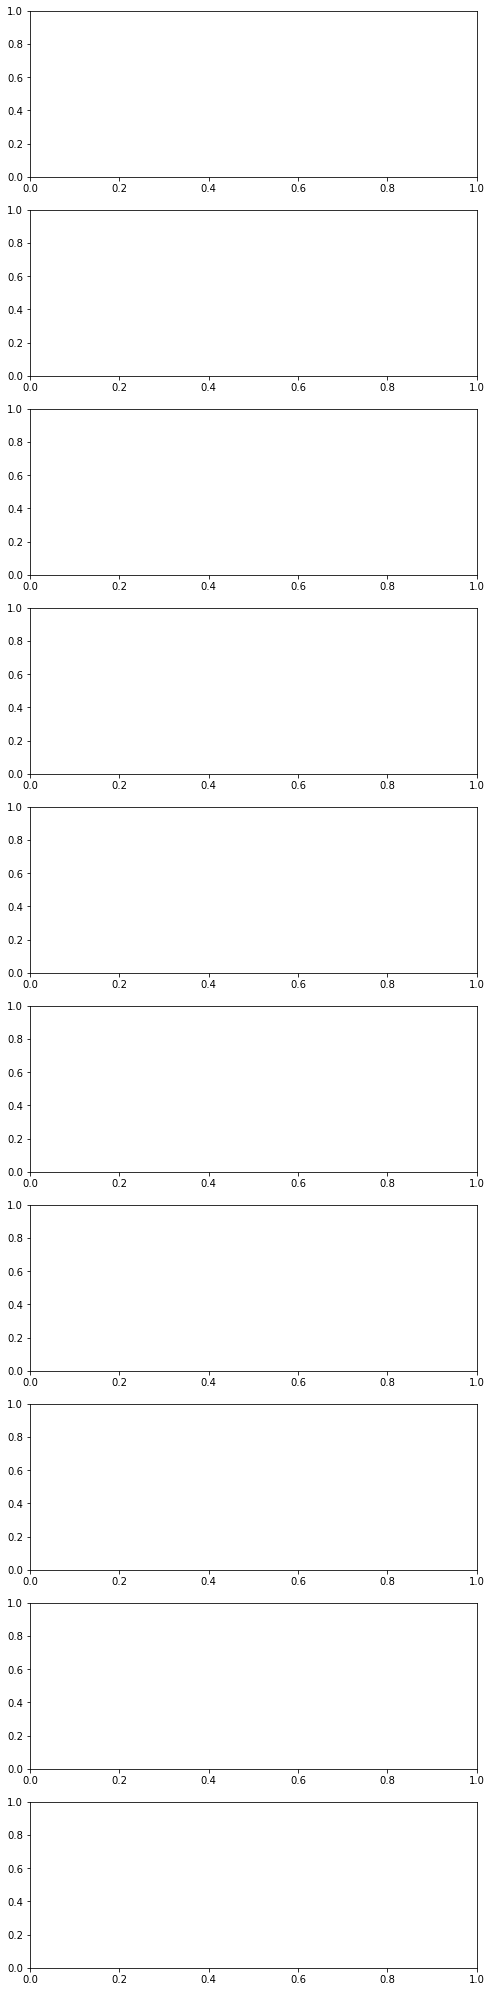

In [15]:
fig, ax = pl.subplots(10, 1, figsize=(8,36))
for i,k in zip(roc_scores.keys(), 500*np.linspace(0.05, 1, 10)):
    l_roc = roc_scores[i][0]
    roc_ratio = (roc_scores[i] - l_roc)/l_roc
    ax[i].errorbar(1000*np.linspace(0.05, 1, 10)/k, roc_ratio, roc_stds[i], 
                   marker='s', mfc='red')
    ax[i].set_title('L fraction: {:}'.format(int(k)))
    ax[i].set_ylim(0., )
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('Ratio of ROC Improvement')

In [ ]:
fig, ax = pl.subplots(1, 1, figsize=(12,4))
for i, k in enumerate(roc_scores.keys()):
    if i%3 == 0:
        ax.errorbar(1000*np.linspace(0.05, 1, 10), roc_scores[k], 
                    0.1*np.array(roc_stds[k]), label=f"L frac: {k:2.2}")
    
# ax.set_title('L fraction: {:}'.format(int(k*500)))
ax.set_ylim(0.8, 0.95)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')
pl.legend(loc='best')
pl.savefig("../figs/l_fraction.pdf")

### Effect of Prob. Threshold

In [ ]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
roc_scores_ex2 = {}
roc_stds_ex2 = {}
for thrs in np.linspace(0.5, .99, 10):
    cl_self = Pipeline([('self-clf', SelfTrainingClassifier(sgd, threshold=thrs))])
    roc_scores_ex2[thrs] = []
    roc_stds_ex2[thrs] = []
    for u_frac in np.linspace(0.001, 1, 10):
        roc, roc_std = self_trainer(ml_trainer=cl_self, 
                           feature_cols=feature_cols,
                           target_col='y',
                           df_train=df_out,
                           df_test=df_test,
                           l_frac=l_frac, 
                           u_frac=u_frac, 
                           n_realization=20)
        roc_scores_ex2[thrs].append(roc)
        roc_stds_ex2[thrs].append(roc_std)

In [ ]:
fig, ax = pl.subplots(10, 1, figsize=(8,36))
for i, k in enumerate(roc_scores_ex2.keys()):
    ax[i].errorbar(np.linspace(0.5, 0.99, 10), roc_scores_ex2[k], roc_stds_ex2[k], 
                   marker='s', 
                   mfc='red')
    ax[i].set_title('Prob. threshold: {:.2}'.format(k))
    ax[i].set_ylim(0.8, 0.95)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')

In [ ]:
fig, ax = pl.subplots(1, 1, figsize=(12,4))
for i, k in enumerate(roc_scores_ex2.keys()):
    if i%3 == 0:
        ax.errorbar(1000*np.linspace(0.05, 1, 10), roc_scores_ex2[k], 
                    0.1*np.array(roc_stds_ex2[k]), label=r"$P > $ "+ f"{k:2.2}")
    
# ax.set_title('L fraction: {:}'.format(int(k*500)))
ax.set_ylim(0.88, 0.92)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('ROC Score')
pl.legend(loc='best')
pl.savefig("../figs/threshold.pdf")

### Perform Analysis using `SemiSupervisedData`